# 0. Pip Installations

In [40]:
# Install all requirements

packages_to_install = ['opendatasets', 'polars', 'nltk', 'wordcloud', 'stop_words', 'torch', 'transformers']
def install_packages(pckg):
    try:
       __import__(pckg)
       print("Successfully imported", pckg)
    except ModuleNotFoundError:
        !pip install {pckg}
        print("Successfully installed", pckg)

for el in packages_to_install:
    install_packages(el)

Successfully imported opendatasets
Successfully imported polars
Successfully imported nltk
Successfully imported wordcloud
Successfully imported stop_words
Successfully imported torch
Successfully imported transformers


In [41]:
import torch
# specify GPU
device = torch.device("cuda")

# 1. Gather data

In [42]:
import opendatasets as od
import polars as pl

od.download("https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset")
file =('sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv')

# Enter kaggle username and api key to download dataset. Api key can be found by following this link:
# https://www.kaggle.com/settings/account

df = pl.read_csv(file,separator=',', encoding='ISO-8859-1')

Skipping, found downloaded files in ".\sentiment-analysis-dataset" (use force=True to force download)


In [43]:
df.head()

polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
i64,i64,str,str,str,str
0,1467810672,"""Mon Apr 06 22:…","""NO_QUERY""","""scotthamilton""","""is upset that …"
0,1467810917,"""Mon Apr 06 22:…","""NO_QUERY""","""mattycus""","""@Kenichan I di…"
0,1467811184,"""Mon Apr 06 22:…","""NO_QUERY""","""ElleCTF""","""my whole body …"
0,1467811193,"""Mon Apr 06 22:…","""NO_QUERY""","""Karoli""","""@nationwidecla…"
0,1467811372,"""Mon Apr 06 22:…","""NO_QUERY""","""joy_wolf""","""@Kwesidei not …"


# 2. Data Preprocessing

## 2.1 Data cleaning

In [44]:
df.null_count()
# No null data

# Rename columns
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Drop columns that are not needed
df = df.select(['sentiment', 'text'])

# Convert polarity to sentiment
# The polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
mapping = {0: 'negative', 2: 'neutral', 4: 'positive'}

df = df.with_columns(pl.col('sentiment').map_dict(mapping).alias('sentiment'))
df.head()

sentiment,text
str,str
"""negative""","""is upset that …"
"""negative""","""@Kenichan I di…"
"""negative""","""my whole body …"
"""negative""","""@nationwidecla…"
"""negative""","""@Kwesidei not …"


## 2.2 Remove Urls

In [45]:
import re

df = df.with_columns(pl.col('text').map_elements(lambda x: re.sub(r"http\S+","", x)))

## 2.3 Remove punctuations and special characters 

In [46]:
import string
df = df.with_columns(pl.col('text').map_elements(lambda x: x.translate(str.maketrans('', '', string.punctuation))))

## 2.4 Lowercase all text

In [47]:
df = df.with_columns(pl.col('text').str.to_lowercase())

## 2.5 Tokenization

In [48]:
df = df.with_columns(pl.col('text')
                     .str.split(by=" ")
                    .alias('tokenized_text'))
cleaned_df = df.drop('text')

## 2.5 Stemming

In [49]:
from nltk.stem import SnowballStemmer
from stop_words import get_stop_words

stemmer = SnowballStemmer('english')
stemmed_df = cleaned_df.with_columns(pl.col('tokenized_text').map_elements(lambda x: [stemmer.stem(word) for word in x if (word and word not in get_stop_words('english'))]).alias('stemmed_text'))

In [50]:
stemmed_df = stemmed_df.drop('tokenized_text')


# 3. Data Exploration

In [51]:
stemmed_df.head()

sentiment,stemmed_text
str,list[str]
"""negative""","[""upset"", ""cant"", … ""blah""]"
"""negative""","[""kenichan"", ""dive"", … ""bound""]"
"""negative""","[""whole"", ""bodi"", … ""fire""]"
"""negative""","[""nationwideclass"", ""behav"", … ""see""]"
"""negative""","[""kwesidei"", ""whole"", ""crew""]"


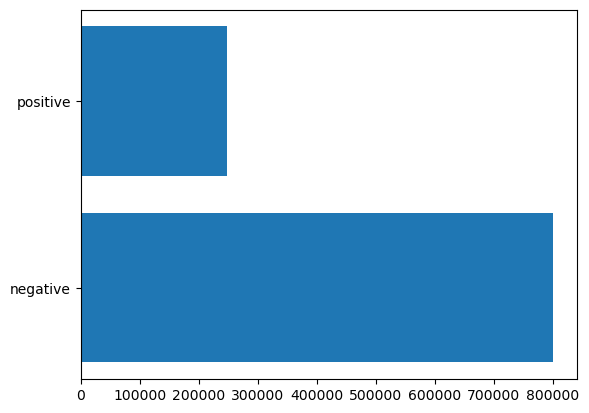

In [52]:
import matplotlib.pyplot as plt

sentiment_count =stemmed_df.select(pl.col('sentiment').value_counts(sort=True)).unnest('sentiment')
plt.barh(y=sentiment_count['sentiment'], width=sentiment_count['counts'])
plt.show()

This indicates more tweets with a negative sentiments than positive sentiments. No tweets could be found with a neutral sentiment.

In [53]:
# Frequency of tokenized words
from collections import Counter
import numpy as np

def count_word_freq(column):
    return Counter([item for sublist in column.to_list() for item in sublist])

freq = count_word_freq(stemmed_df.get_column('stemmed_text'))
freq_negative_sentiment = count_word_freq(stemmed_df.filter(pl.col('sentiment') == 'negative').get_column('stemmed_text'))
freq_positive_sentiment = count_word_freq(stemmed_df.filter(pl.col('sentiment') == 'positive').get_column('stemmed_text'))

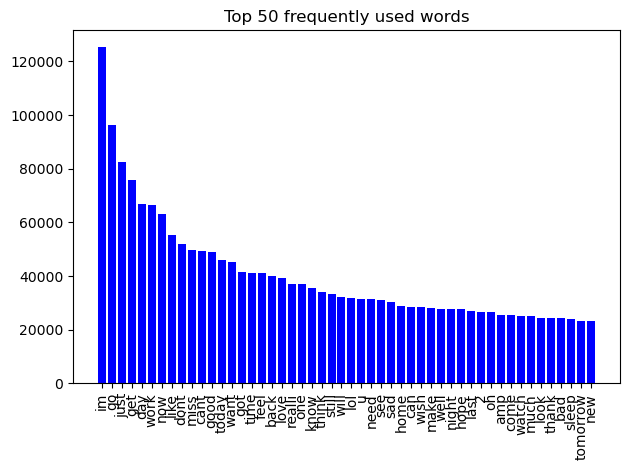

In [54]:
# Visualize top 50 frequently used words
word, frequency = zip(*freq.most_common(n=50))
indices = np.arange(len(freq.most_common(n=50)))
plt.bar(indices, frequency, color='b')
plt.xticks(indices, word, rotation='vertical')
plt.title('Top 50 frequently used words')
plt.tight_layout()
plt.show()

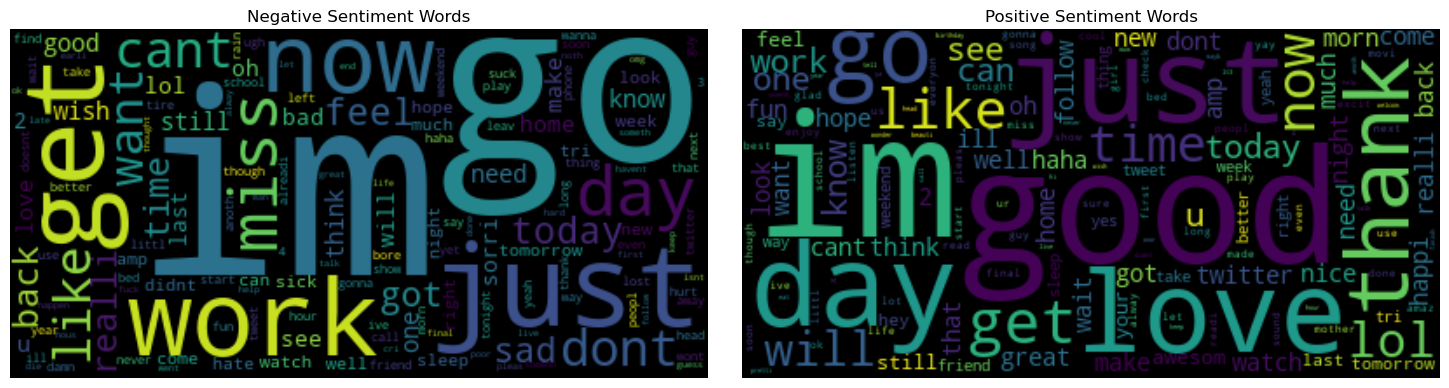

In [55]:
# Create wordcloud
import wordcloud

fig, (ax1, ax2) = plt.subplots(1, 2)

pos_cloud = wordcloud.WordCloud(max_words=150, random_state=30, collocations=True)
neg_cloud = wordcloud.WordCloud(max_words=150, random_state=30, collocations=True)
negative_sentiment_cloud = neg_cloud.generate_from_frequencies(dict(freq_negative_sentiment.most_common()))
positive_sentiment_cloud = pos_cloud.generate_from_frequencies(dict(freq_positive_sentiment.most_common()))

ax1.imshow(negative_sentiment_cloud, interpolation='bilinear')
ax1.set_title('Negative Sentiment Words')
ax1.axis('off')
ax2.imshow(positive_sentiment_cloud, interpolation='bilinear')
ax2.set_title('Positive Sentiment Words')
ax2.axis('off')

fig.tight_layout()
fig.set_size_inches(15,15)

# 4. Text Vectorization

In [56]:
# Create model for word vectorization

from gensim.models import FastText

X = stemmed_df.select('stemmed_text')
y = stemmed_df.select('sentiment')



def train_model():
    vector_size = 100

    new_fasttext_model = FastText(vector_size= vector_size, window= 3, min_count= 1, sg=1)
    new_fasttext_model.build_vocab(X.to_series().to_list())
    new_fasttext_model.train(X.to_series().to_list(), total_examples=new_fasttext_model.corpus_count, epochs=5)

    new_fasttext_model.save("fasttext.model")

    return new_fasttext_model

def get_fasttext_model():
    try:
        pretrained_model = FastText.load("fasttext.model")
        print("Successfully loaded pretrained model")
        return pretrained_model
    except AttributeError:
        print("Training new model")
        return train_model()

fasttext_model = get_fasttext_model()

Successfully loaded pretrained model


In [57]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.to_series().to_list(), y.to_series().to_list(), test_size=0.2, random_state=42)


X_train_vectors = []
for sentence in X_train:
    sentence_vectors = []
    for token in sentence:
        try:
            word_vector = fasttext_model.wv[token]
            sentence_vectors.append(word_vector)
        except KeyError:
            # Handle out-of-vocabulary words here, e.g., replace with a placeholder vector
            pass

    if len(sentence_vectors) > 0:
        # Calculate the average of word vectors for the sentence
        sentence_vector = np.mean(sentence_vectors, axis=0)
        X_train_vectors.append(sentence_vector)
    else:
        pass

X_test_vectors = []
for sentence in X_test:
    sentence_vectors = []
    for token in sentence:
        try:
            word_vector = fasttext_model.wv[token]
            sentence_vectors.append(word_vector)
        except KeyError:
            pass

    if len(sentence_vectors) > 0:
        sentence_vector = np.mean(sentence_vectors, axis=0)
        X_test_vectors.append(sentence_vector)
    else:
        pass

print(X_train_vectors[1])
print(X_test_vectors[1])


[ 0.19707796 -0.29473168 -0.43172345  0.21443993 -0.29432982 -0.13609523
 -0.13493048  0.62419766 -0.06001837 -0.11589948 -0.30011353 -0.23967049
 -0.23719454  0.6058188   0.19481881  0.10710634 -0.17130521 -0.06850467
 -0.44332486 -0.6185435  -0.22517914  0.08618411 -0.3440568  -0.48899773
 -0.13072999 -0.22038169 -0.06969714  0.10437404  0.28704128 -0.04105551
 -0.5148877  -0.02197108  0.6213062   0.11512525 -0.02944958  0.09182575
 -0.61161876  0.00874139 -0.17887402  0.29287595 -0.28768712 -0.51915175
  0.07353263 -0.18404326 -0.9433401  -0.37462157 -0.22191666  0.0445605
 -0.1648327   0.42912766  0.44866368 -0.07061598  0.5939426   0.13140734
 -0.36468711 -0.65889275  0.33174923  0.12854175 -0.1128516  -0.04838854
  0.5245389  -0.15359873 -0.64468414  0.46336192  0.11636139  0.29765606
 -0.03552323  0.08978882  0.11932462  0.3986498  -0.17858909  0.5198529
  0.18108004 -0.35390046  0.30516085  0.04691501  0.4544976  -0.06521162
 -0.02432554  0.49588814 -0.53482413 -0.01299996  0.0

## 5. Model (BERT)